In [1]:
# Setting up the Colab environment. DO NOT EDIT!
import os
#import warnings
#warnings.filterwarnings("ignore")

try:
    import otter, pingouin

except ImportError:
    ! pip install -q otter-grader==4.0.0, pingouin
    import otter

if not os.path.exists('walkthrough-tests'):
    zip_files = [f for f in os.listdir() if f.endswith('.zip')]
    assert len(zip_files)>0, 'Could not find any zip files!'
    assert len(zip_files)==1, 'Found multiple zip files!'
    ! unzip {zip_files[0]}

grader = otter.Notebook(colab=True,
                        tests_dir = 'walkthrough-tests')

# Walkthrough

## Learning Objectives
At the end of this learning activity you will be able to:
 - Practice using `pg.normality` and `pg.qqplot` to assess normality.
 - Practice using `pg.linear_regression` to perform multiple regression.
 - Interpret the results of linear regression such as the coefficient, p-value, R^2, and confidence intervals.
 - Describe a _residual_ and how to interpret it.
 - Relate the _dummy variable trap_ and how to avoid it during regression.
 - Describe _overfitting_ and how to avoid it.

As we discussed with Dr. Devlin in the introduction video, this week and next we are going to look at HIV neurocognitive impairment data from a cohort here at Drexel.
Each person was given a full-scale neuropsychological exam and the resulting values were aggregated and normalized into Z-scores based on demographically matched healthy individuals.

In this walkthrough we will explore the effects of antiretroviral medications on neurological impairment.
In our cohort, we have two major drug regimens, d4T (Stavudine) and the newer Emtricitabine/tenofovir (Truvada).
The older Stavudine is suspected to have neurotoxic effects that are not found in the newer Truvada.
We will use inferential statistics to understand this effect.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import pingouin as pg

%matplotlib inline

In [3]:
data = pd.read_csv('hiv_neuro_data.csv')
data['education'] = data['education'].astype(float)
data.head()

,sex,age,education,race,processing_domain_z,exec_domain_z,language_domain_z,visuospatial_domain_z,learningmemory_domain_z,motor_domain_z,ART,YearsSeropositive
0,male,62,10.0,AA,0.5,0.6,0.151646,-1.0,-1.152131,-1.364306,Stavudine,13
1,male,56,10.0,AA,-0.5,1.2,-0.255505,-2.0,-0.086376,-0.348600,Truvada,19
2,female,51,10.0,AA,0.5,0.1,0.902004,-0.4,-1.139892,0.112215,Stavudine,9
3,female,47,12.0,AA,-0.6,-1.2,-0.119866,-2.1,0.803619,-2.276768,Truvada,24
4,male,46,13.0,AA,-0.4,1.3,0.079129,-1.3,-0.533607,-0.330541,Truvada,14


Before we start, we need to talk about assumptions.

Basic linear regression has a number assumptions baked into itself:
 - **Linearity**: The relationship between the independent variables (predictors) and the dependent variable (outcome) is linear. This means that changes in the predictors lead to proportional changes in the dependent variable.
 - **The relationship between the independent variables and the dependent variable is additive**: The effect of changes in an independent variable X on the dependent variable Y is consistent, regardless of the values of other independent variables. This assumption might not hold if there are interaction effects between independent variables that affect the dependent variable.
 - **Independence**: Observations are independent of each other. This means that the observations do not influence each other, an assumption that is particularly important in time-series data where time-related dependencies can violate this assumption.
 - **Homoscedasticity**: The variance of error terms (residuals) is constant across all levels of the independent variables. In other words, as the predictor variable increases, the spread (variance) of the residuals remains constant. This is evaluated at the **end** of the fit.
 - **Normal Distribution of Errors**: The residuals (errors) of the model are normally distributed. This assumption is especially important for hypothesis testing (e.g., t-tests of coefficients) and confidence interval construction. It's worth noting that for large sample sizes, the Central Limit Theorem helps mitigate the violation of this assumption. This is evaluated at the **end** of the fit.
 - **Minimal Multicollinearity**: The independent variables need to be independent of each other. Multicollinearity doesn't affect the fit of the model as much as it affects the coefficients' estimates, making them unstable and difficult to interpret.
 - **No perfect multicollinearity**: Also called the _dummy variable trap_. It states that none of the independent variables should be a perfect linear function of other independent variables. We'll talk more about this when we run into it.

Biology itself is highly non-linear.
That doesn't mean we can't use linear assumptions to explore biological questions, it just means that we need to be mindful when interpretting the results.

## Exploration

Let's start by plotting the each variable against EDZ.

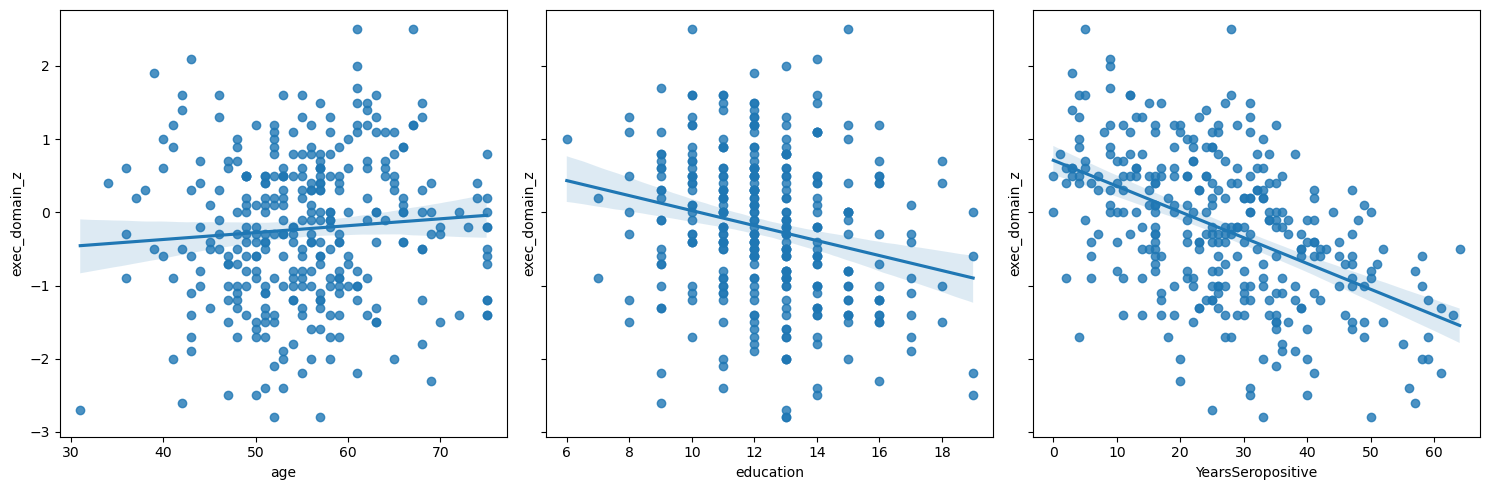

In [4]:
fig, (age_ax, edu_ax, ys_ax) = plt.subplots(1,3, sharey=True, figsize = (15, 5))

sns.regplot(data = data,
            x = 'age',
            y = 'exec_domain_z',
            ax=age_ax)

sns.regplot(data = data,
            x = 'education',
            y = 'exec_domain_z',
            ax=edu_ax)

sns.regplot(data = data,
            x = 'YearsSeropositive',
            y = 'exec_domain_z',
            ax=ys_ax)

fig.tight_layout()

### Q1: By inspection, which variable is most correlated?

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 3  |

_Points:_ 5

In [5]:
# Answer: age, education, YearsSeropositive
q1_most_correlated = 'YearsSeropositive' # SOLUTION

In [ ]:
grader.check("q1_initial_correlation")

<Axes: xlabel='ART', ylabel='exec_domain_z'>

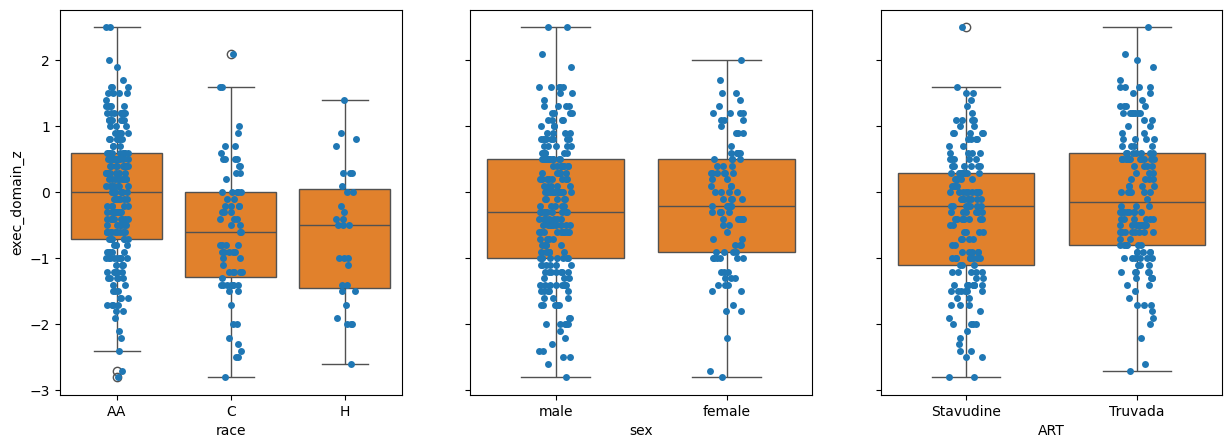

In [9]:
fig, (race_ax, sex_ax, art_ax) = plt.subplots(1,3, sharey=True, figsize = (15, 5))

sns.stripplot(data=data,
            x = 'race',
            y = 'exec_domain_z', ax=race_ax)
sns.boxplot(data=data,
            x = 'race',
            y = 'exec_domain_z', ax=race_ax)

sns.stripplot(data=data,
            x = 'sex',
            y = 'exec_domain_z', ax=sex_ax)
sns.boxplot(data=data,
            x = 'sex',
            y = 'exec_domain_z', ax=sex_ax)

sns.stripplot(data=data,
            x = 'ART',
            y = 'exec_domain_z', ax=art_ax)
sns.boxplot(data=data,
            x = 'ART',
            y = 'exec_domain_z', ax=art_ax)

### Q2: By inspection, which variable has the most between class difference?

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 3  |

_Points:_ 5

In [10]:
# Answer: race, sex, ART
q2_most_bcd = 'race' # SOLUTION

In [ ]:
grader.check("q2_initial_bcd")

## Basic regression

We'll start by taking the simplest approach and regress the most correlated value first.

`pg.linear_regression` works by regressing all columns in the first parameter against the single column in the second.
By convention, we usually use the variables `X` and `y`.

You'll often see this written as:

$\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}$

In the case of `pg.linear_regression` the $\boldsymbol{\epsilon}$ is added by default and we do not need to specify it.

You do not have to use the variable names `X` and `y`, in many cases you might have multiple `X`s and `y`s, but for simplicity, I will stick with this simple convention.

In [14]:
X = data['YearsSeropositive'] # Our independent variables
y = data['exec_domain_z']     # Our dependent variable
res = pg.linear_regression(X, y)
res

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.711625,0.105822,6.724733,7.994463e-11,0.236815,0.234453,0.503437,0.919812
1,YearsSeropositive,-0.035258,0.003522,-10.011320,1.000644e-20,0.236815,0.234453,-0.042186,-0.028329


This has fit the equation:

`PDZ = -0.035*YS + 0.712`

It tells us that the likelihood of this slope being zero is 1.0E-20 and that years-seropositive explains ~23.6% of variation in EDZ that we observe.

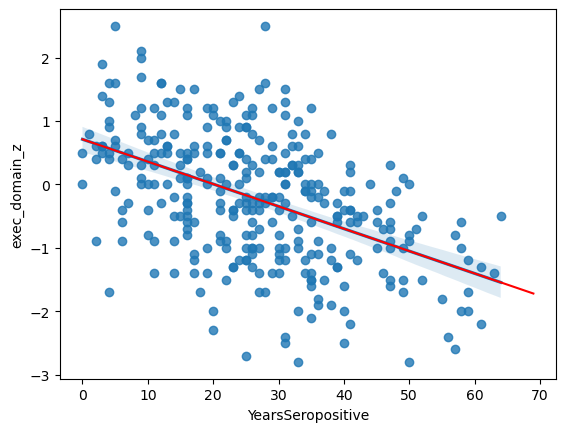

In [15]:
ax = sns.regplot(data = data,
                 x = 'YearsSeropositive',
                 y = 'exec_domain_z')

# Pick "years seropositive" from 0 to 70
x = np.arange(0, 70)

# Use the coefficients from above in a linear equation
y = res.loc[1, 'coef']*x + res.loc[0, 'coef']

ax.plot(x, y, color = 'r')

## Residuals

_Residuals_ are the difference between the observed value and the predicted value.
In the case of a simple linear regression, this is the y-distance between each point and the best-fit line.
Examining these is an import step in assessing the fit for any biases.
You can think of the residual as what is "left over" after the regression.

We could calculate these ourselves from the regression coefficients, but, `pingouin` conviently provides them for us.
The result `DataFrame` from `pg.linear_regression` has a special attribute `.residuals_` which stores the difference between the prediction and reality for each point in the dataset.

In [16]:
print(res.residuals_[:5])

[ 0.34672285  1.15826787 -0.29430717 -1.06544462  1.08198035]


In order to test the **Homoscedasticity** we want to ensure that these residuals are _not correlated with the depenendant variable_.

In our case, this means that the model is equally good predicting the EDZ of people recently infected with HIV and those who have been living with HIV for a long time.

To do this, we plot the residuals vs each independent variable.

<Axes: xlabel='YearsSeropositive'>

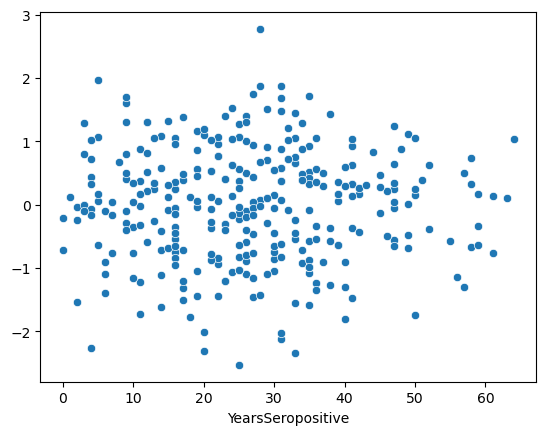

In [17]:
sns.scatterplot(x=data['YearsSeropositive'],  y=res.residuals_)

This is an ideal residual plot.
It should look like a random "stary-night sky" centered around 0.
This implies that the model is not better or worse for any given X value.

Let's also test our assumption about a normal distribution of errors of the residuals.

### Q3: Are the residuals normally distributed?

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 5  |

_Points:_ 5

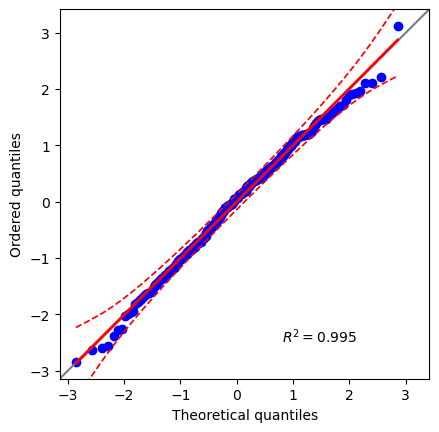

In [18]:
# Create a Q-Q plot of the residuals

q3_plot = pg.qqplot(res.residuals_)  # SOLUTION

In [19]:
# Use the Jarque-Bera normal test for large sample sizes

q3_norm_res = pg.normality(res.residuals_, method='jarque_bera')  # SOLUTION

In [20]:
# Are the residuals normally distributed? 'yes' or 'no'

q3_is_norm = 'yes' # SOLUTION

In [ ]:
grader.check("q3_resid_normality")

You don't need to do this test at every stage, but it is a good test to do before you are _done_.

## Multiple Regression

Regression is not limited to a single independent variable, you can add as many as you'd like.

In our case, there are two others that we should consider: `age` and `education`

In [26]:
X = data[['YearsSeropositive', 'education', 'age']]
y = data['exec_domain_z']
res = pg.linear_regression(X, y)
res

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.977449,0.404718,2.415135,1.628781e-02,0.318207,0.311835,0.181214,1.773685
1,YearsSeropositive,-0.037462,0.003390,-11.049854,2.853764e-24,0.318207,0.311835,-0.044132,-0.030792
2,education,-0.102647,0.020406,-5.030176,8.170366e-07,0.318207,0.311835,-0.142794,-0.062500
3,age,0.019297,0.005546,3.479295,5.721793e-04,0.318207,0.311835,0.008385,0.030209


Now, it has fit the equation:

`EDZ = -0.037*YS - 0.103*edu + 0.019*age + 0.977`

The education is significant at p=8.17E-7.
Be caution when comparing coefficients, we might be tempted to compare -0.0422 and -0.0506 and say that education has a more negative effect than YS ...
But, remember that education ranges from 0-12 and YS ranges from 0-60, these are not on the same scale and are not directly comparable.
We'll talk about how to compare relative importance later.

As before, we should check the residuals of the model against _each_ independent variable in the regression to check for homoscedasticity.

<Axes: xlabel='age'>

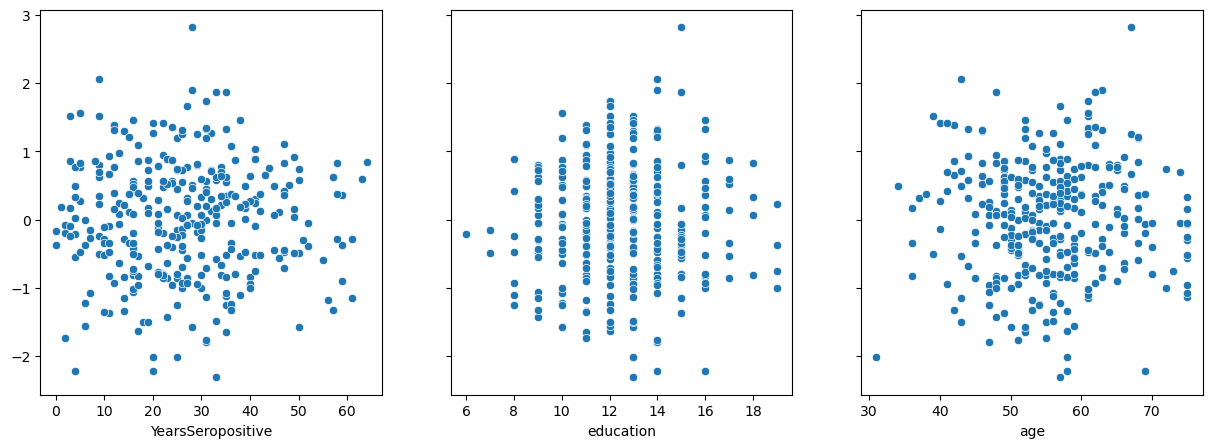

In [27]:
fig, (ys_ax, edu_ax, age_ax) = plt.subplots(1,3, sharey=True, figsize = (15, 5))

sns.scatterplot(x=data['YearsSeropositive'],  y=res.residuals_, ax=ys_ax)
sns.scatterplot(x=data['education'],  y=res.residuals_, ax=edu_ax)
sns.scatterplot(x=data['age'],  y=res.residuals_, ax=age_ax)

Three more stary night skies. Perfect.

Remember, the residual is the difference between the prediction of the model and reality.
Therefore, we can also use the residual plots to see how well the regression is handling other variables we have not included in the model.
If the model has properly accounted for something, the residual plot should stay centered around 0.

This can be done for categorical or continious variables.

<Axes: xlabel='ART'>

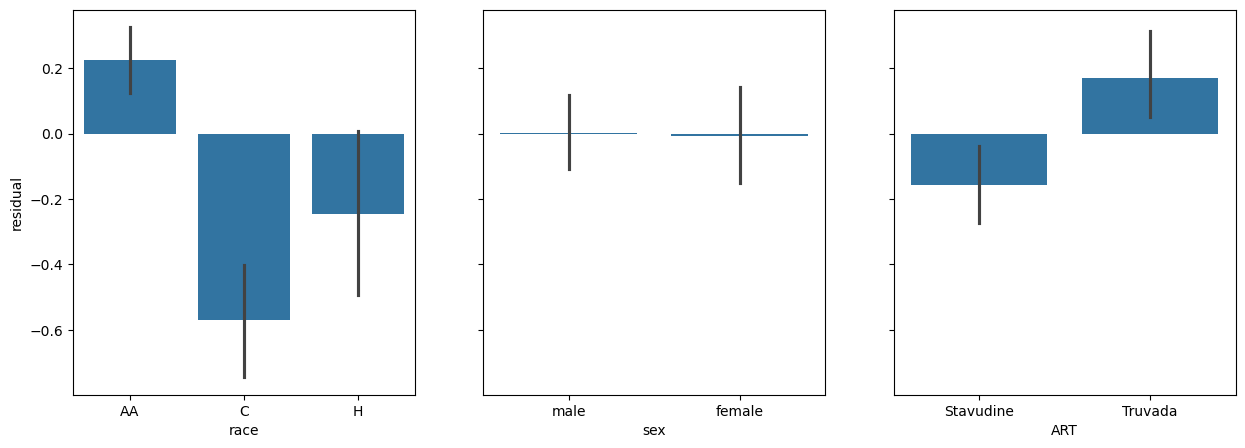

In [28]:
fig, (race_ax, sex_ax, art_ax) = plt.subplots(1,3, sharey=True, figsize = (15, 5))

race_ax.set_ylabel('residual')

sns.barplot(x=data['race'],  y=res.residuals_, ax=race_ax)
sns.barplot(x=data['sex'],  y=res.residuals_, ax=sex_ax)
sns.barplot(x=data['ART'],  y=res.residuals_, ax=art_ax)

Here we see some interesting patterns:
 - The graph of race against residuals shows us that our model is signifacntly racially biased. AA individuals are significantly 'under-estimated' by the model, C individauals are significantly over-estimated, and H individuals are significantly over-estimated.
 - The graph of sex shows that there is no real difference in the residuals. It has accounted for sex already.
 - It looks like there is a real difference across ART.

## _ANCOVA_

What we have done above is create a model that _accounts_ for the effects of age, education, and YS on EDZ.
We **subtracted** that effect (the predicted value) from the observed value thus creating the _residual_.
This is what is "left over" in the observed value after accounting for covariates or nuisance variables.
Then we plotted the _residual_ against each of our categorical variables.
If we then took the ANOVA of these residuals we'd be testing the hypothesis:
 _When accounting for age, education, and YS is there a difference across race._
 
This process is called an _Analysis of covariance_ or an **ANCOVA**.

### Standard first

### Q4: Perform an ANOVA between ART on the Executive Domain Z-score.

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 4  |

_Points:_ 5

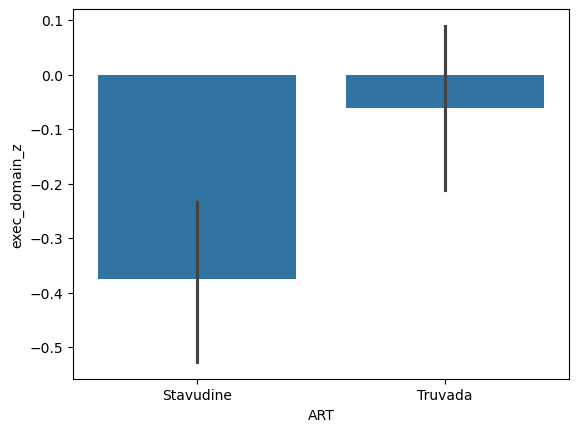

In [29]:
# Create a plot showing the effect of ART on EDZ
q4_plot = sns.barplot(data = data, x = 'ART', y = 'exec_domain_z') # SOLUTION

In [30]:
# Perform an ANOVA testing the impact of ART on EDZ
q4_res = pg.anova(data, dv = 'exec_domain_z', between = 'ART') # SOLUTION
q4_res

,Source,ddof1,ddof2,F,p-unc,np2
0,ART,1,323,7.809699,0.005507,0.023608


In [31]:
# Does ART have a significant impact on Executive Domain? 'yes' or 'no'?

q4_art_impact = 'yes' # SOLUTION

In [ ]:
grader.check("q4_art_test")

### With correction

Nicely `pingouin` has something built right in to do this whole process.

,Source,SS,DF,F,p-unc,np2
0,ART,11.879147,1,17.470083,3.770731e-05,0.051768
1,YearsSeropositive,79.888814,1,117.488585,1.585741e-23,0.268552
2,education,20.033725,1,29.462623,1.128191e-07,0.084308
3,age,17.992537,1,26.460747,4.697743e-07,0.076374
4,Residual,217.590675,320,NaN,NaN,NaN


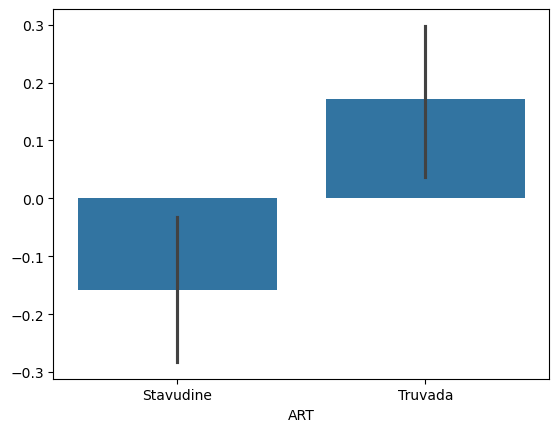

In [37]:
sns.barplot(x=data['ART'],  y=res.residuals_)

# An ANCOVA testing the impact of ART on EDZ
# after correcting for the impace of age, education and YS
pg.ancova(data,
          dv = 'exec_domain_z',
          between = 'ART',
          covar=['YearsSeropositive', 'education', 'age'])

We can notice that after correction for covaraites the F-value has increased and the p-value has decreased.
This means the analysis is attributing more difference to race after correction and is more sure this is not due to noise.

The _advantage_ of using the `pg.ancova` function is that you can easily and quickly do your analysis.
The _disadvantage_ is that you cannot examine the internal regression for Normality and Homoscedasticity.

But, what if we wanted to have a covariate that is a category like race?

## Regression with categories

So, how do you do regression with a category like race?

Could it be as simple as adding it the `X` matrix?

In [38]:
# X = data[['YearsSeropositive', 'education', 'age', 'race']]
# y = data['processing_domain_z']
# res = pg.linear_regression(X, y)
# res

Would have been nice, but we need to get a little tricky and use _dummy_ variables.

In their simplest terms, dummy variables are binary representations of categories.
Like so.

In [39]:
pd.get_dummies(data['race']).head()

,AA,C,H
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [40]:
# Extracting the same continious variables
X = data[['YearsSeropositive', 'education', 'age']]

# Creating new dummy variables for race
dummy_vals = pd.get_dummies(data['race']).astype(float)


# Adding them the end
X = pd.concat([X, dummy_vals], axis=1)

y = data['exec_domain_z']

res = pg.linear_regression(X, y)
res.round(3)

/opt/tljh/user/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 6 with 7 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.194,0.294,-0.661,0.509,0.453,0.444,-0.772,0.383
1,YearsSeropositive,-0.046,0.003,-14.133,0.000,0.453,0.444,-0.052,-0.039
2,education,-0.054,0.019,-2.795,0.006,0.453,0.444,-0.092,-0.016
3,age,0.031,0.005,5.868,0.000,0.453,0.444,0.021,0.041
4,AA,0.410,0.104,3.941,0.000,0.453,0.444,0.205,0.615
5,C,-0.583,0.149,-3.914,0.000,0.453,0.444,-0.876,-0.290
6,H,-0.021,0.132,-0.162,0.871,0.453,0.444,-0.282,0.239


This _Warning_ is telling us that our model has fallen into the _dummy variable trap_.
The dummy variable trap occurs when dummy variables created for categorical data in a regression model are perfectly collinear, meaning one variable can be predicted from the others, leading to redundancy.
This happens because the inclusion of all dummy variables for a category along with a constant term (intercept) creates a situation where the sum of the dummy variables plus the intercept equals one, introducing perfect multicollinearity.
To avoid this, one dummy variable should be dropped to serve as the reference category, ensuring the model's design matrix is full rank and the regression coefficients are estimable and interpretable.

In [41]:
pd.get_dummies(data['race'], drop_first=True).head()

,C,H
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [42]:
X = data[['YearsSeropositive', 'education', 'age']]
dummy_vals = pd.get_dummies(data['race'], drop_first=True).astype(float)
X = pd.concat([X, dummy_vals], axis=1)
y = data['exec_domain_z']
res = pg.linear_regression(X, y)
res.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.216,0.381,0.567,0.571,0.453,0.444,-0.534,0.966
1,YearsSeropositive,-0.046,0.003,-14.133,0.000,0.453,0.444,-0.052,-0.039
2,education,-0.054,0.019,-2.795,0.006,0.453,0.444,-0.092,-0.016
3,age,0.031,0.005,5.868,0.000,0.453,0.444,0.021,0.041
4,C,-0.993,0.115,-8.642,0.000,0.453,0.444,-1.219,-0.767
5,H,-0.432,0.147,-2.942,0.004,0.453,0.444,-0.720,-0.143


We can notice a few things here:
 - **AA** has become the 'reference', the coefficients of C and H are relative to AA, which is set at 0.
   - C individuals have a decreased score (relative to AA), which is significant.
   - H individuals have an decreased score (relative to AA), which is significant.

We can look at the residuals.

<Axes: xlabel='ART'>

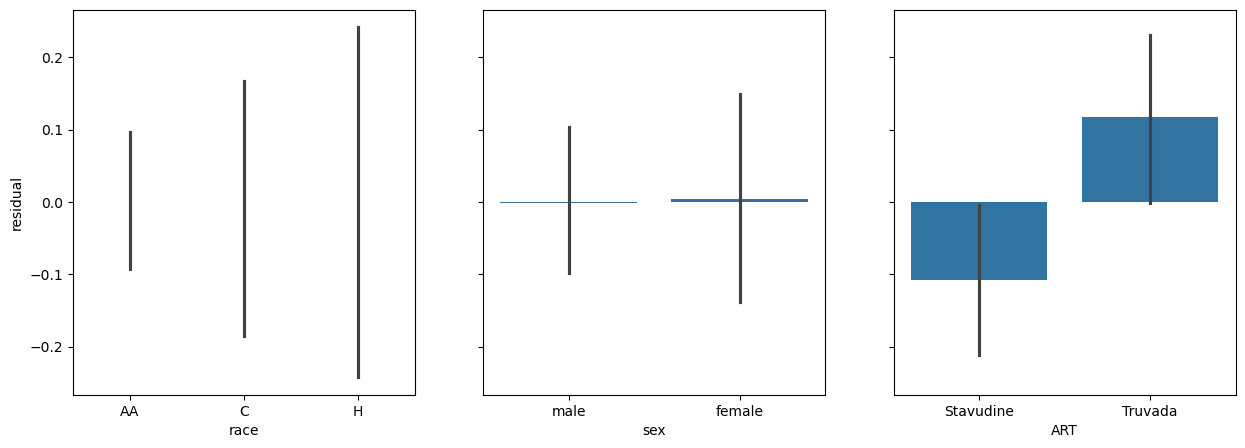

In [43]:
fig, (race_ax, sex_ax, art_ax) = plt.subplots(1,3, sharey=True, figsize = (15, 5))

race_ax.set_ylabel('residual')

sns.barplot(x=data['race'],  y=res.residuals_, ax=race_ax)
sns.barplot(x=data['sex'],  y=res.residuals_, ax=sex_ax)
sns.barplot(x=data['ART'],  y=res.residuals_, ax=art_ax)

Let's merge everything into a single analysis.

In [44]:
X = pd.concat([data[['YearsSeropositive', 'education', 'age']],
               pd.get_dummies(data['race'], drop_first=True).astype(float),
               pd.get_dummies(data['sex'], drop_first=True).astype(float),
               pd.get_dummies(data['ART'], drop_first=True).astype(float),
              ], axis=1)
y = data['exec_domain_z']
res = pg.linear_regression(X, y)
res.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.367,0.419,-0.877,0.381,0.47,0.458,-1.191,0.456
1,YearsSeropositive,-0.044,0.003,-13.747,0.000,0.47,0.458,-0.051,-0.038
2,education,-0.060,0.019,-3.107,0.002,0.47,0.458,-0.098,-0.022
3,age,0.039,0.006,6.746,0.000,0.47,0.458,0.028,0.051
4,C,-0.940,0.115,-8.189,0.000,0.47,0.458,-1.165,-0.714
5,H,-0.382,0.146,-2.612,0.009,0.47,0.458,-0.670,-0.094
6,male,-0.014,0.092,-0.158,0.875,0.47,0.458,-0.195,0.166
7,Truvada,0.315,0.098,3.203,0.001,0.47,0.458,0.122,0.508


Here our _reference_ is an AA, female taking Stavudine.
 - Everything is signifiant except for sex.
 - We see that Truvada has a _significant positive_ effect on EDZ relative to Stavudine.

Since this is our final model, let's test our last normality assumption.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

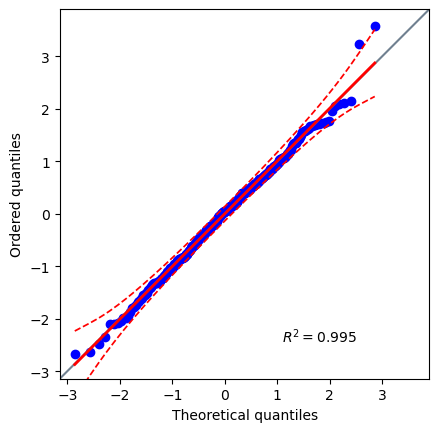

In [45]:
pg.qqplot(res.residuals_)

In [46]:
pg.normality(res.residuals_, method='normaltest')

,W,pval,normal
0,0.832024,0.659672,True


Perfect, now we know that our final model passes the _Normal Distribution of Errors_ assumption.

What about understanding which parameters have the largest impact on the model?
Stated another way: which features are most important to determing EDZ?

Nicely, `pingouin` can do this for us.

In [47]:
res_with_imp = pg.linear_regression(X, y, relimp=True)
res_with_imp

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,-0.367108,0.418546,-0.877105,3.810941e-01,0.46984,0.458133,-1.190587,0.456370,NaN,NaN
1,YearsSeropositive,-0.044294,0.003222,-13.746688,4.748977e-34,0.46984,0.458133,-0.050633,-0.037954,0.275883,58.718414
2,education,-0.059910,0.019281,-3.107223,2.059458e-03,0.46984,0.458133,-0.097844,-0.021975,0.039358,8.376948
3,age,0.039215,0.005813,6.745778,7.231020e-11,0.46984,0.458133,0.027777,0.050652,0.039614,8.431478
4,C,-0.939704,0.114749,-8.189228,6.513749e-15,0.46984,0.458133,-1.165470,-0.713939,0.075652,16.101683
5,H,-0.382354,0.146409,-2.611538,9.442348e-03,0.46984,0.458133,-0.670411,-0.094297,0.015979,3.400943
6,male,-0.014446,0.091578,-0.157748,8.747561e-01,0.46984,0.458133,-0.194624,0.165732,0.000484,0.102939
7,Truvada,0.314984,0.098327,3.203452,1.495929e-03,0.46984,0.458133,0.121529,0.508440,0.022870,4.867595


In [48]:
# After filtering and sorting
res_with_imp.query('pval<0.01').sort_values('relimp_perc', ascending=False)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
1,YearsSeropositive,-0.044294,0.003222,-13.746688,4.748977e-34,0.46984,0.458133,-0.050633,-0.037954,0.275883,58.718414
4,C,-0.939704,0.114749,-8.189228,6.513749e-15,0.46984,0.458133,-1.165470,-0.713939,0.075652,16.101683
3,age,0.039215,0.005813,6.745778,7.231020e-11,0.46984,0.458133,0.027777,0.050652,0.039614,8.431478
2,education,-0.059910,0.019281,-3.107223,2.059458e-03,0.46984,0.458133,-0.097844,-0.021975,0.039358,8.376948
7,Truvada,0.314984,0.098327,3.203452,1.495929e-03,0.46984,0.458133,0.121529,0.508440,0.022870,4.867595
5,H,-0.382354,0.146409,-2.611538,9.442348e-03,0.46984,0.458133,-0.670411,-0.094297,0.015979,3.400943


## Over fitting

In principle we can continue to add more and more variables to the `X` and just let the computer figure out the p-value of each.

There are a few reasons we shouldn't take this tack.
 - **Overfitting** : A larger model will **ALWAYS** fit better than a smaller model. This doesn't mean the larger model is **better** at predicting _all samples_, it just means it fits **these** samples better.
 - **Explainability** : Large models with many parameters are difficult to explain and reason about. We are biologists, not data scientists. Our job is to reason about the _result_ of the analysis, not create the best fitting model.
 - **Statistical power** : As you add more noise features you lose the power to detect real features.

So, you should limit yourself to only those features that you think are biologically meaningful.

When planning experiments there are a couple of things you can do to avoid overfitting:
 - **Sample size** : While there is no strict rule, you should plan to have _at least_ 10 samples per feature in your model.
 - **Even sampling** : It is ideal to have a roughly equal representation of the entire parameter space. If you have categories, you should have an equal number of each. If you have continious data, you should have both high and low values. If you have many parameters, you should have an equal number of each of their interactions as well.

These are good guidelines for all model-fitting style analyses.

In [49]:
print('Features:', len(X.columns))
print('Obs:', len(X.index))

Features: 7
Obs: 325


## Even more regression

There are a number of regression based tools in `pingouin` that we didn't cover that may be useful to explore.
 - `pg.logistic_regression` : This works similar to linear regression but is for binary dependent variables.
Each feature is regressed to create an equation that estimates the likelihood of the `dv` being `True`.
 - `pg.partial_corr` : Like the ANCOVA, this is a tool for removing the effect of covariates and then calculating a correlation coefficient.
 - `pg.rm_corr` : Correlation with repeated measures. This is useful if you have measured the same _sample_ multiple times and want to account for intermeasurment variability.
 - `pg.mediation_analysis` : Tests the hypothesis that the independent variable `X` influences the dependent variable `Y` by a change in mediator `M`; like so `X -> M -> Y`.
This is useful to disentangle causal effects from covariation.

---------------------------------------------

In [50]:
grader.check_all()